In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')
jayeshlandge_cremad_path = kagglehub.dataset_download('jayeshlandge/cremad')

print('Data source import complete.')


100%|██████████| 429M/429M [00:04<00:00, 101MB/s]

Extracting files...


100%|██████████| 428M/428M [00:02<00:00, 176MB/s]

Extracting files...


100%|██████████| 107M/107M [00:00<00:00, 237MB/s] 

Extracting files...


100%|██████████| 451M/451M [00:03<00:00, 121MB/s]

Extracting files...


Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import os
import sys
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, BatchNormalization, GRU,
    Input, Flatten, Dropout, Activation,
    Conv1D, MaxPooling1D, AveragePooling1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [4]:
ravdess = uwrfkaggler_ravdess_emotional_speech_audio_path + "/audio_speech_actors_01-24/"

ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_24', 'Actor_20', 'Actor_05', 'Actor_01', 'Actor_19', 'Actor_07', 'Actor_12', 'Actor_11', 'Actor_13', 'Actor_03', 'Actor_21', 'Actor_14', 'Actor_17', 'Actor_04', 'Actor_18', 'Actor_10', 'Actor_08', 'Actor_02', 'Actor_06', 'Actor_09', 'Actor_16', 'Actor_23', 'Actor_15', 'Actor_22']


In [10]:
Crema = jayeshlandge_cremad_path + "/AudioWAV/"

# TESS
Tess = ejlok1_toronto_emotional_speech_set_tess_path + "/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"

# SAVEE
Savee = ejlok1_surrey_audiovisual_expressed_emotion_savee_path + "/ALL/"

In [6]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [7]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())

   Emotions                                               Path
0   neutral  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1     happy  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
2  surprise  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
3     happy  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
4       sad  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...


/tmp/ipython-input-7-2022143484.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


In [11]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

In [12]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
neutral     400
happy       400
disgust     400
surprise    400
sad         400
angry       400
fear        400
Name: count, dtype: int64


**SAVEE Dataset**

In [13]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
sad          60
happy        60
angry        60
fear         60
disgust      60
surprise     60
Name: count, dtype: int64


**Integration**

In [14]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1,happy,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
2,surprise,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
3,happy,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
4,sad,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...


In [15]:
print(data_path.Emotions.value_counts())


Emotions
happy       1923
angry       1923
sad         1923
disgust     1923
fear        1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

In [16]:
data,sr = librosa.load(file_path[0],mono=True)
sr

22050

In [17]:
ipd.Audio(data,rate=sr)

# Data augmentation

In [18]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)


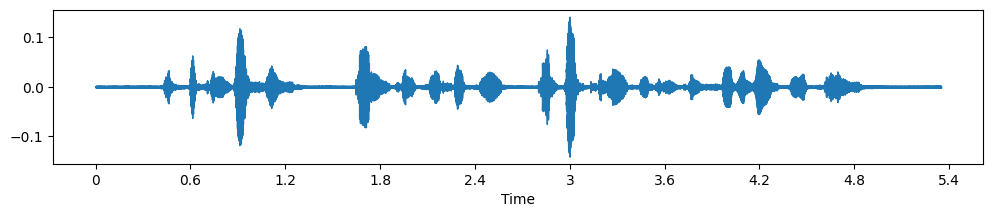

In [19]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 2))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

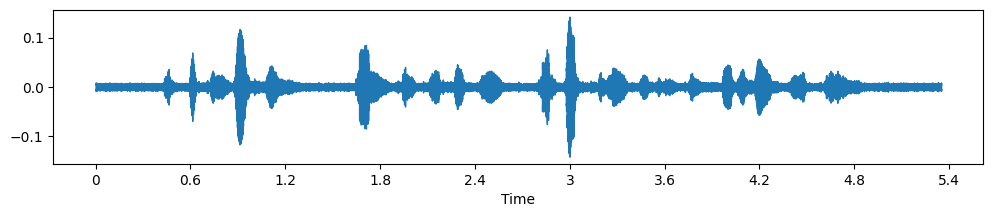

In [20]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,2))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

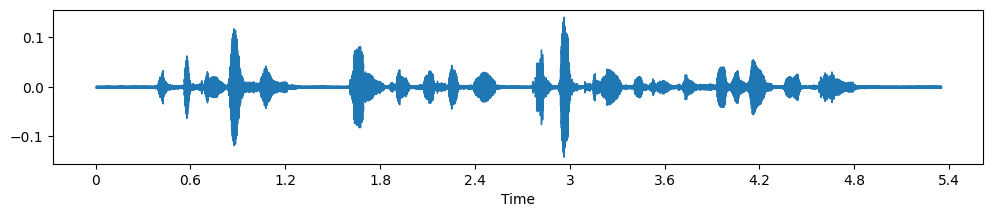

In [22]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,2))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

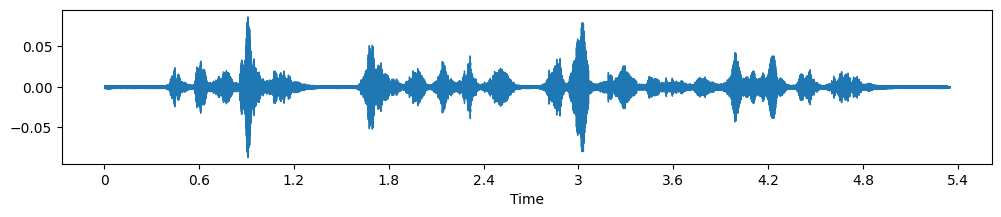

In [23]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 2))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [24]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)


def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [25]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


# Noraml way to get features

In [26]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

2it [00:00,  9.55it/s]

0 audio has been processed


502it [01:06,  8.95it/s]

500 audio has been processed


1002it [02:08,  8.37it/s]

1000 audio has been processed


1502it [03:09, 10.98it/s]

1500 audio has been processed


2002it [04:01, 10.85it/s]

2000 audio has been processed


2503it [04:52, 10.58it/s]

2500 audio has been processed


3002it [05:43, 11.61it/s]

3000 audio has been processed


3502it [06:34,  9.93it/s]

3500 audio has been processed


4003it [07:27, 11.25it/s]

4000 audio has been processed


4502it [08:17,  5.39it/s]

4500 audio has been processed


5001it [09:05, 10.74it/s]

5000 audio has been processed


5502it [09:57, 10.62it/s]

5500 audio has been processed


6003it [10:52, 11.22it/s]

6000 audio has been processed


6502it [11:43, 11.91it/s]

6500 audio has been processed


7003it [12:35, 11.10it/s]

7000 audio has been processed


7503it [13:28, 11.13it/s]

7500 audio has been processed


8002it [14:18, 11.29it/s]

8000 audio has been processed


8503it [15:09, 10.46it/s]

8500 audio has been processed


9002it [15:59, 13.82it/s]

9000 audio has been processed


9502it [16:45, 13.64it/s]

9500 audio has been processed


10003it [17:31, 10.87it/s]

10000 audio has been processed


10503it [18:15, 12.31it/s]

10500 audio has been processed


11003it [19:00, 16.47it/s]

11000 audio has been processed


11504it [19:38, 15.83it/s]

11500 audio has been processed


12002it [20:29, 10.05it/s]

12000 audio has been processed


12162it [20:47,  9.75it/s]

Done
Time:  1247.703457613


In [27]:
len(X), len(Y), data_path.Path.shape


(48648, 48648, (12162,))

# Saving features

In [28]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.170898,0.170898,0.170898,0.051270,0.000000,0.000000,0.081055,0.160156,0.288574,0.492676,...,5.295945,3.763684,2.548267,0.938825,-0.874077,-2.186749,-2.686058,-2.336200,-1.380387,neutral
1,0.252930,0.375977,0.497559,0.498047,0.492188,0.494141,0.494629,0.489258,0.488770,0.494141,...,-1.825591,1.174274,-1.365167,1.465893,3.534132,4.601184,2.380523,1.257986,3.391557,neutral
2,0.312012,0.433594,0.556152,0.540527,0.560547,0.593750,0.623047,0.606934,0.574219,0.584473,...,2.328424,1.569307,0.683608,0.072180,-0.028883,-0.079497,-0.639169,-1.498931,-1.901990,neutral
3,0.239746,0.371094,0.497559,0.509277,0.513672,0.510742,0.518066,0.514648,0.510742,0.501953,...,2.082366,-2.945344,-5.600221,-1.290596,-0.712497,-2.667157,2.620785,1.943901,-0.661900,neutral
4,0.342773,0.508301,0.586914,0.533203,0.557129,0.552246,0.697266,0.835938,0.650879,0.719238,...,4.336390,3.803665,3.591209,2.159716,-0.526108,-2.877524,-3.422336,-2.330954,-0.924679,happy


In [29]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.170898,0.170898,0.170898,0.051270,0.000000,0.000000,0.081055,0.160156,0.288574,0.492676,...,5.295945,3.763684,2.548267,0.938825,-0.874077,-2.186749,-2.686058,-2.336200,-1.380387,neutral
1,0.252930,0.375977,0.497559,0.498047,0.492188,0.494141,0.494629,0.489258,0.488770,0.494141,...,-1.825591,1.174274,-1.365167,1.465893,3.534132,4.601184,2.380523,1.257986,3.391557,neutral
2,0.312012,0.433594,0.556152,0.540527,0.560547,0.593750,0.623047,0.606934,0.574219,0.584473,...,2.328424,1.569307,0.683608,0.072180,-0.028883,-0.079497,-0.639169,-1.498931,-1.901990,neutral
3,0.239746,0.371094,0.497559,0.509277,0.513672,0.510742,0.518066,0.514648,0.510742,0.501953,...,2.082366,-2.945344,-5.600221,-1.290596,-0.712497,-2.667157,2.620785,1.943901,-0.661900,neutral
4,0.342773,0.508301,0.586914,0.533203,0.557129,0.552246,0.697266,0.835938,0.650879,0.719238,...,4.336390,3.803665,3.591209,2.159716,-0.526108,-2.877524,-3.422336,-2.330954,-0.924679,happy


In [ ]:
print(Emotions.isna().any())


In [30]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
1616        False
1617        False
1618        False
1619        False
Emotions    False
Length: 1621, dtype: bool


(48648, 1621)

In [ ]:
np.sum(Emotions.isna())

# Data preparation

In [31]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [32]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [33]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 1620)

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 1620), (38918, 7), (9730, 1620), (9730, 7))

In [35]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [36]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 1620), (38918, 7), (9730, 1620), (9730, 7))

> Applying early stopping for all models


In [44]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint(
    'best_model1_weights.h5', monitor='val_accuracy', save_best_only=True
)

early_stop = EarlyStopping(
    monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=1e-5, mode='max'
)


In [45]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 1620, 1), (38918, 7), (9730, 1620, 1), (9730, 7))

In [50]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 1620, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1620, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 810, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 810, 512)       │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 810, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 405, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 405, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 203, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 203, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 203, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 102, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 102, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6528)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,342,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,59

 Total params: 5,620,359 (21.44 MB)

 Trainable params: 5,616,007 (21.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [51]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3895 - loss: 1.7009

609/609 ━━━━━━━━━━━━━━━━━━━━ 120s 180ms/step - accuracy: 0.3896 - loss: 1.7005 - val_accuracy: 0.4284 - val_loss: 1.4853 - learning_rate: 0.0010
Epoch 2/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 128s 167ms/step - accuracy: 0.5151 - loss: 1.2444 - val_accuracy: 0.4006 - val_loss: 1.7136 - learning_rate: 0.0010
Epoch 3/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5546 - loss: 1.1434

609/609 ━━━━━━━━━━━━━━━━━━━━ 146s 174ms/step - accuracy: 0.5546 - loss: 1.1433 - val_accuracy: 0.5435 - val_loss: 1.1799 - learning_rate: 0.0010
Epoch 4/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6040 - loss: 1.0329

609/609 ━━━━━━━━━━━━━━━━━━━━ 137s 166ms/step - accuracy: 0.6040 - loss: 1.0329 - val_accuracy: 0.5621 - val_loss: 1.1673 - learning_rate: 0.0010
Epoch 5/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6381 - loss: 0.9529

609/609 ━━━━━━━━━━━━━━━━━━━━ 146s 174ms/step - accuracy: 0.6381 - loss: 0.9528 - val_accuracy: 0.5935 - val_loss: 1.0751 - learning_rate: 0.0010
Epoch 6/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6657 - loss: 0.8720

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 174ms/step - accuracy: 0.6657 - loss: 0.8720 - val_accuracy: 0.5938 - val_loss: 1.0951 - learning_rate: 0.0010
Epoch 7/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6990 - loss: 0.7844

609/609 ━━━━━━━━━━━━━━━━━━━━ 101s 166ms/step - accuracy: 0.6990 - loss: 0.7843 - val_accuracy: 0.6933 - val_loss: 0.8174 - learning_rate: 0.0010
Epoch 8/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7662 - loss: 0.6331

609/609 ━━━━━━━━━━━━━━━━━━━━ 147s 173ms/step - accuracy: 0.7662 - loss: 0.6331 - val_accuracy: 0.6971 - val_loss: 0.8521 - learning_rate: 0.0010
Epoch 9/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7965 - loss: 0.5538

609/609 ━━━━━━━━━━━━━━━━━━━━ 105s 172ms/step - accuracy: 0.7965 - loss: 0.5537 - val_accuracy: 0.7608 - val_loss: 0.6398 - learning_rate: 0.0010
Epoch 10/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8510 - loss: 0.4145

609/609 ━━━━━━━━━━━━━━━━━━━━ 138s 166ms/step - accuracy: 0.8510 - loss: 0.4144 - val_accuracy: 0.7876 - val_loss: 0.5907 - learning_rate: 0.0010
Epoch 11/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8510 - loss: 0.4175

609/609 ━━━━━━━━━━━━━━━━━━━━ 101s 165ms/step - accuracy: 0.8511 - loss: 0.4174 - val_accuracy: 0.7928 - val_loss: 0.5979 - learning_rate: 0.0010
Epoch 12/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8760 - loss: 0.3450

609/609 ━━━━━━━━━━━━━━━━━━━━ 106s 173ms/step - accuracy: 0.8761 - loss: 0.3448 - val_accuracy: 0.8706 - val_loss: 0.3729 - learning_rate: 0.0010
Epoch 13/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8991 - loss: 0.2853

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 174ms/step - accuracy: 0.8992 - loss: 0.2852 - val_accuracy: 0.8867 - val_loss: 0.3232 - learning_rate: 0.0010
Epoch 14/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.9335 - loss: 0.1931 - val_accuracy: 0.7490 - val_loss: 0.7865 - learning_rate: 0.0010
Epoch 15/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 147s 173ms/step - accuracy: 0.8934 - loss: 0.3006 - val_accuracy: 0.8831 - val_loss: 0.3510 - learning_rate: 0.0010
Epoch 16/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9212 - loss: 0.2231

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 174ms/step - accuracy: 0.9212 - loss: 0.2230 - val_accuracy: 0.9188 - val_loss: 0.2400 - learning_rate: 0.0010
Epoch 17/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 137s 165ms/step - accuracy: 0.9624 - loss: 0.1131 - val_accuracy: 0.9098 - val_loss: 0.2744 - learning_rate: 0.0010
Epoch 18/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9621 - loss: 0.1097

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.9621 - loss: 0.1097 - val_accuracy: 0.9395 - val_loss: 0.2033 - learning_rate: 0.0010
Epoch 19/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 105s 172ms/step - accuracy: 0.9690 - loss: 0.0912 - val_accuracy: 0.9030 - val_loss: 0.3132 - learning_rate: 0.0010
Epoch 20/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - accuracy: 0.9352 - loss: 0.1903 - val_accuracy: 0.9319 - val_loss: 0.2119 - learning_rate: 0.0010
Epoch 21/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9724 - loss: 0.0835
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
609/609 ━━━━━━━━━━━━━━━━━━━━ 137s 165ms/step - accuracy: 0.9724 - loss: 0.0835 - val_accuracy: 0.9095 - val_loss: 0.2829 - learning_rate: 0.0010
Epoch 22/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9541 - loss: 0.1392

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.9541 - loss: 0.1390 - val_accuracy: 0.9659 - val_loss: 0.1171 - learning_rate: 5.0000e-04
Epoch 23/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9884 - loss: 0.0400

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.9884 - loss: 0.0400 - val_accuracy: 0.9698 - val_loss: 0.1012 - learning_rate: 5.0000e-04
Epoch 24/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 105s 173ms/step - accuracy: 0.9880 - loss: 0.0395 - val_accuracy: 0.9635 - val_loss: 0.1269 - learning_rate: 5.0000e-04
Epoch 25/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 138s 166ms/step - accuracy: 0.9659 - loss: 0.1075 - val_accuracy: 0.9687 - val_loss: 0.1080 - learning_rate: 5.0000e-04
Epoch 26/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9857 - loss: 0.0454

609/609 ━━━━━━━━━━━━━━━━━━━━ 147s 174ms/step - accuracy: 0.9857 - loss: 0.0454 - val_accuracy: 0.9706 - val_loss: 0.1048 - learning_rate: 5.0000e-04
Epoch 27/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 137s 165ms/step - accuracy: 0.9919 - loss: 0.0302 - val_accuracy: 0.9705 - val_loss: 0.1070 - learning_rate: 5.0000e-04
Epoch 28/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.9891 - loss: 0.0336 - val_accuracy: 0.9694 - val_loss: 0.1141 - learning_rate: 5.0000e-04
Epoch 29/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9844 - loss: 0.0470

609/609 ━━━━━━━━━━━━━━━━━━━━ 147s 173ms/step - accuracy: 0.9844 - loss: 0.0470 - val_accuracy: 0.9719 - val_loss: 0.1126 - learning_rate: 5.0000e-04
Epoch 30/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9922 - loss: 0.0257

609/609 ━━━━━━━━━━━━━━━━━━━━ 105s 173ms/step - accuracy: 0.9922 - loss: 0.0257 - val_accuracy: 0.9729 - val_loss: 0.1017 - learning_rate: 5.0000e-04
Epoch 31/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 137s 165ms/step - accuracy: 0.9947 - loss: 0.0181 - val_accuracy: 0.9709 - val_loss: 0.1156 - learning_rate: 5.0000e-04
Epoch 32/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.9897 - loss: 0.0315 - val_accuracy: 0.9670 - val_loss: 0.1169 - learning_rate: 5.0000e-04
Epoch 33/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9892 - loss: 0.0349
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
609/609 ━━━━━━━━━━━━━━━━━━━━ 146s 173ms/step - accuracy: 0.9892 - loss: 0.0349 - val_accuracy: 0.9674 - val_loss: 0.1361 - learning_rate: 5.0000e-04
Epoch 34/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9950 - loss: 0.0169

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - accuracy: 0.9950 - loss: 0.0169 - val_accuracy: 0.9760 - val_loss: 0.0979 - learning_rate: 2.5000e-04
Epoch 35/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9960 - loss: 0.0138

609/609 ━━━━━━━━━━━━━━━━━━━━ 137s 166ms/step - accuracy: 0.9960 - loss: 0.0138 - val_accuracy: 0.9772 - val_loss: 0.0936 - learning_rate: 2.5000e-04
Epoch 36/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9972 - loss: 0.0106 - val_accuracy: 0.9764 - val_loss: 0.0912 - learning_rate: 2.5000e-04
Epoch 37/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9962 - loss: 0.0136

609/609 ━━━━━━━━━━━━━━━━━━━━ 101s 165ms/step - accuracy: 0.9962 - loss: 0.0136 - val_accuracy: 0.9774 - val_loss: 0.0905 - learning_rate: 2.5000e-04
Epoch 38/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9972 - loss: 0.0101

609/609 ━━━━━━━━━━━━━━━━━━━━ 101s 165ms/step - accuracy: 0.9972 - loss: 0.0101 - val_accuracy: 0.9778 - val_loss: 0.0959 - learning_rate: 2.5000e-04
Epoch 39/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.9969 - loss: 0.0119 - val_accuracy: 0.9769 - val_loss: 0.0945 - learning_rate: 2.5000e-04
Epoch 40/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9964 - loss: 0.0117

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.9964 - loss: 0.0117 - val_accuracy: 0.9786 - val_loss: 0.0952 - learning_rate: 2.5000e-04
Epoch 41/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9977 - loss: 0.0080 - val_accuracy: 0.9765 - val_loss: 0.0944 - learning_rate: 2.5000e-04
Epoch 42/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 147s 173ms/step - accuracy: 0.9956 - loss: 0.0141 - val_accuracy: 0.9732 - val_loss: 0.1128 - learning_rate: 2.5000e-04
Epoch 43/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9902 - loss: 0.0296
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
609/609 ━━━━━━━━━━━━━━━━━━━━ 137s 165ms/step - accuracy: 0.9902 - loss: 0.0296 - val_accuracy: 0.9746 - val_loss: 0.0984 - learning_rate: 2.5000e-04
Epoch 44/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9973 - loss: 0.0090 - val_accuracy: 0.9773 - val_loss: 0.0910 - learning_rate: 1.2500e-04
Epoch 45/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/s

In [53]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9794 - loss: 0.0997
Accuracy of our model on test data :  97.86227941513062 %


In [54]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


,Predicted Labels,Actual Labels
0,disgust,disgust
1,fear,fear
2,neutral,neutral
3,disgust,disgust
4,disgust,disgust
5,fear,fear
6,sad,sad
7,disgust,disgust
8,neutral,neutral
9,sad,sad


In [ ]:
df0

# Evalutation

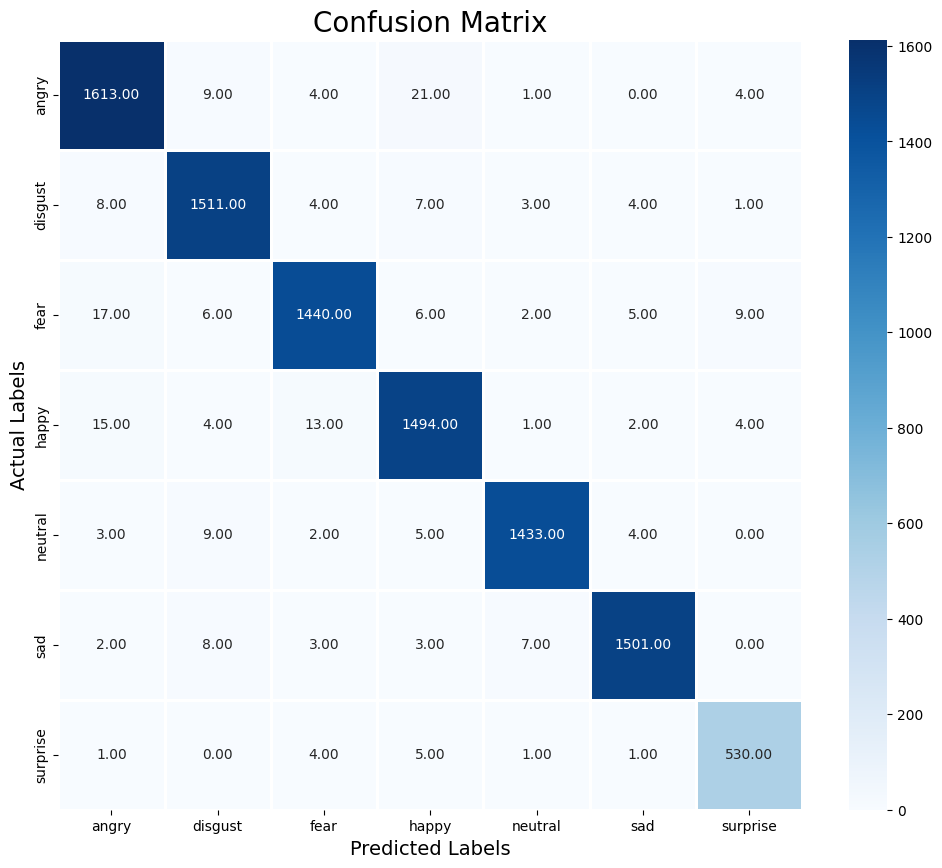

              precision    recall  f1-score   support

       angry       0.97      0.98      0.97      1652
     disgust       0.98      0.98      0.98      1538
        fear       0.98      0.97      0.97      1485
       happy       0.97      0.97      0.97      1533
     neutral       0.99      0.98      0.99      1456
         sad       0.99      0.98      0.99      1524
    surprise       0.97      0.98      0.97       542

    accuracy                           0.98      9730
   macro avg       0.98      0.98      0.98      9730
weighted avg       0.98      0.98      0.98      9730



In [55]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [61]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk
